In [2]:
# CHANGE ME: Set this to the path to the NuPlan data directory
NUPLAN_DATA_PATH = "~/nuplan-v1.1/splits/mini/"

In [60]:
import typing
from dataclasses import dataclass
import numpy as np
import numpy.typing as npt

@dataclass
class State:
    quaternion: npt.NDArray[np.float64]
    velocity: npt.NDArray[np.float64]
    position: npt.NDArray[np.float64]


Observation: typing.TypeAlias = tuple[State, State]
Action: typing.TypeAlias = tuple[float, float]

In [96]:
import os
trajectories: list[list[State]] = []

def getFiles(path: str) -> list[str]:
    path = os.path.expanduser(path)
    files = [os.path.join(path, f) for f in os.listdir(path)]
    return [f for f in files if os.path.isfile(f)]

file_iter = iter(getFiles(NUPLAN_DATA_PATH))

In [97]:
import sqlite3

for file_path in file_iter:
    trajectory = []
    with sqlite3.connect(file_path) as conn:
        cur = conn.cursor()
        for (vx, vy, vz, qw, qx, qy, qz, x, y, z) in cur.execute("SELECT vx, vy, vz, qw, qx, qy, qz, x, y, z FROM ego_pose"):
            s = State(quaternion=np.array([qx, qy, qz, qw]), velocity=np.array([vx, vy, vz]), position=np.array([x, y, z]))
            trajectory.append(s)
    trajectories.append(trajectory)
    print(f"Loaded trajectory of len {len(trajectory)} from {file_path}")

Loaded trajectory of len 48525 from /home/fidgetsinner/nuplan-v1.1/splits/mini/2021.08.17.17.17.01_veh-45_02314_02798.db
Loaded trajectory of len 36197 from /home/fidgetsinner/nuplan-v1.1/splits/mini/2021.10.05.07.10.04_veh-52_01442_01802.db
Loaded trajectory of len 38438 from /home/fidgetsinner/nuplan-v1.1/splits/mini/2021.06.09.12.39.51_veh-26_05620_06003.db
Loaded trajectory of len 39790 from /home/fidgetsinner/nuplan-v1.1/splits/mini/2021.08.30.14.54.34_veh-40_00439_00835.db
Loaded trajectory of len 18494 from /home/fidgetsinner/nuplan-v1.1/splits/mini/2021.10.11.02.57.41_veh-50_00352_00535.db
Loaded trajectory of len 45185 from /home/fidgetsinner/nuplan-v1.1/splits/mini/2021.06.28.15.02.02_veh-38_02398_02848.db
Loaded trajectory of len 39394 from /home/fidgetsinner/nuplan-v1.1/splits/mini/2021.10.06.07.26.10_veh-52_00006_00398.db
Loaded trajectory of len 46200 from /home/fidgetsinner/nuplan-v1.1/splits/mini/2021.06.09.17.37.09_veh-12_00404_00864.db
Loaded trajectory of len 55090 f

KeyboardInterrupt: 

In [ ]:
# z is up, x is forward, y is left

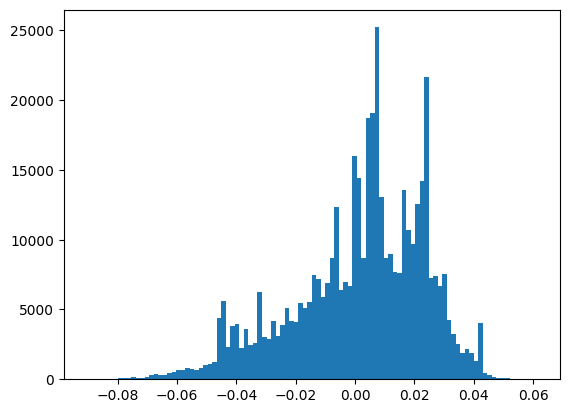

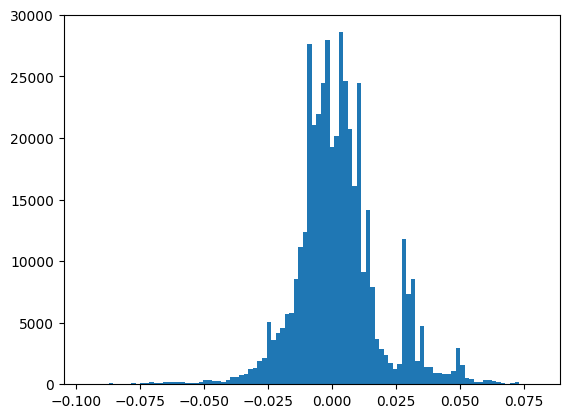

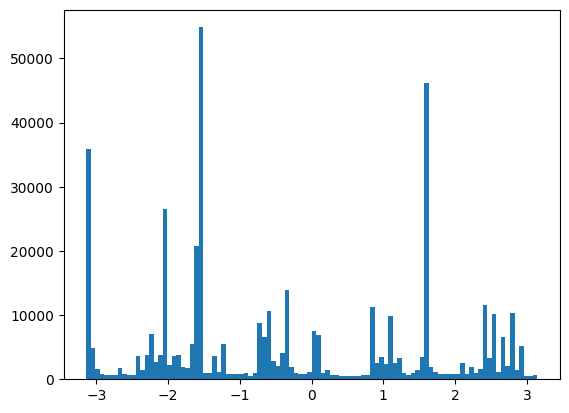

In [98]:
import numpy
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt


rolls = []
pitches = []
yaws = []


for i, t in enumerate(trajectories):
    for s in t:
        r = Rotation.from_quat(s.quaternion)
        rolls.append(r.as_euler('xyz')[0])
        pitches.append(r.as_euler('xyz')[1])
        yaws.append(r.as_euler('xyz')[2])

plt.hist(rolls, label='roll', bins=100)
plt.show()
plt.hist(pitches, label='pitch', bins=100)
plt.show()
plt.hist(yaws, label='yaw', bins=100)
plt.show()

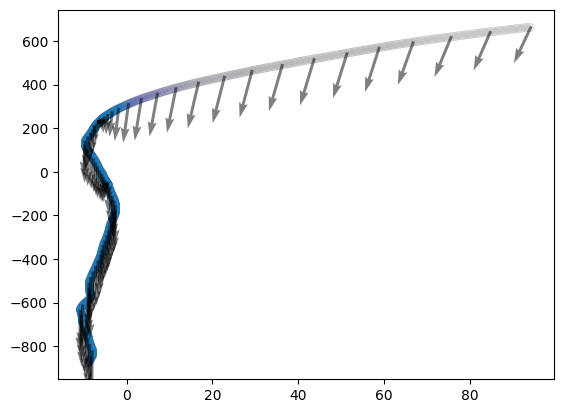

In [123]:
subsection = trajectories[5][:20000]


xs = np.array([s.position[0] for s in subsection])
ys = np.array([s.position[1] for s in subsection])
zs = np.array([s.position[2] for s in subsection])

xs -= np.mean(xs)
ys -= np.mean(ys)
zs -= np.mean(zs)

rs = [Rotation.from_quat(s.quaternion) for s in subsection]

qintv = 200

qxs = np.array([xs[i] for i in range(len(ys)) if i % qintv == 0])
qys = np.array([ys[i] for i in range(len(ys)) if i % qintv == 0])
qxvs, qyvs = np.stack([rs[i].apply(subsection[i].velocity) for i in range(len(xs)) if i % qintv == 0])[:, :2].T


plt.scatter(xs, ys, alpha=0.005)
plt.quiver(qxs, qys, qxvs, qyvs, alpha=0.5)
plt.show()

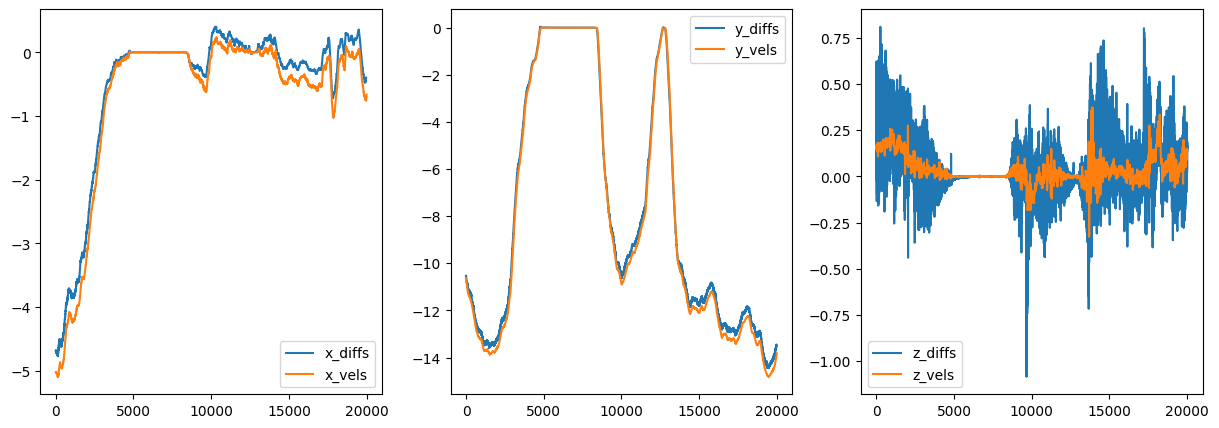

In [125]:
subsection = trajectories[5][:20000]

x_diffs = []
x_vels = []

y_diffs = []
y_vels = []

z_diffs = []
z_vels = []

for i in range(len(subsection)-1):
    s0 = subsection[i]
    s1 = subsection[i+1]

    r = Rotation.from_quat(s0.quaternion)    
    global_v = r.apply(s0.velocity)

    x_diffs.append(s1.position[0] - s0.position[0])
    x_vels.append(global_v[0])

    y_diffs.append(s1.position[1] - s0.position[1])
    y_vels.append(global_v[1])

    z_diffs.append(s1.position[2] - s0.position[2])
    z_vels.append(global_v[2])


x_diffs = np.array(x_diffs)
x_vels = np.array(x_vels)


# running average of 20 
x_diffs = np.convolve(x_diffs, np.ones(30), 'valid') / 30
x_diffs *= 100

y_diffs = np.array(y_diffs)
y_diffs = np.convolve(y_diffs, np.ones(30), 'valid') / 30

y_diffs *= 100
y_vels = np.array(y_vels)

z_diffs = np.array(z_diffs)
z_diffs *= 100
z_vels = np.array(z_vels)



plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(x_diffs, label='x_diffs')
plt.plot(x_vels, label='x_vels')
plt.legend()    

plt.subplot(1, 3, 2)
plt.plot(y_diffs, label='y_diffs')
plt.plot(y_vels, label='y_vels')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(z_diffs, label='z_diffs')
plt.plot(z_vels, label='z_vels')
plt.legend()


In [31]:
import numpy as np

def normalize_angle(angle: float) -> float:
    """
    Normalize the angle to [-pi, pi)
    """
    return (angle + np.pi) % (2 * np.pi) - np.pi

for s in trajectories[0]:
    heading = s.heading
    veldir = np.arctan2(s.velocity[1], s.velocity[0])
    print(normalize_angle(heading - veldir), np.linalg.norm(s.velocity))

-0.0004416419805415295 7.597181050074947
-0.0007740908612330344 7.594884827435215
-0.0012701172938465177 7.589369546122814
-0.001433257631828333 7.587278692715502
-0.0018718731150850765 7.5839233638469254
-0.002343693522735446 7.580791981527156
-0.002858575287042253 7.577128716127418
-0.0033099455757503726 7.573849900664122
-0.0033569804880340115 7.572680289701424
-0.0036270582884059266 7.568451164753413
-0.0037195216495056194 7.566675134428943
-0.003874928235089392 7.562264884306661
-0.003899114601793041 7.558649518701192
-0.0037269809570559254 7.556332472177732
-0.003631411752287761 7.553433305685012
-0.003449470858542636 7.551738987775071
-0.0034807362134090525 7.546097899981013
-0.0033199229275466813 7.541723945541815
-0.0030657819676531695 7.540211869416097
-0.003051760376957091 7.537053671799246
-0.0030837694137999527 7.532140637242289
-0.0030264372057184907 7.527959757434198
-0.0029258192800658556 7.525329841575911
-0.002665153878535609 7.523643262834827
-0.002425028451494615 7.